# 🚀 High-Performance ML Pipeline using Transformer Model + XGBoost Multi Label Classifer

This notebook implements a streamlined, high-performance solution for detecting:

- 🚫 **Spam Reviews**: Low-quality, repetitive, or fake reviews
- 🚫 **Advertisements**: Promotional content in reviews
- 🚫 **Rant Without Visit**: Complaints from users who never actually visited

**Approach**:

- **SentenceTransformers** (`all-MiniLM-L6-v2`) for fast 384-dim text embeddings
- **Metadata feature engineering** for comprehensive signals
- **XGBoost** classifiers with hyperparameter tuning
- **Multi-task classification** with optimized F1, precision, and recall

<br>

---


## 📦 1. Setup and Installation

First, let's install required packages and import libraries.


In [33]:
# Install required packages
import subprocess
import sys


def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")
    except:
        print(f"⚠️  {package} installation failed, might already be installed")


# Install key packages
packages = [
    "sentence-transformers",
    "xgboost",
    "scikit-learn",
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
]

print("📦 Installing required packages...")
for package in packages:
    install_package(package)

print("\n🎉 All packages ready!")

📦 Installing required packages...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ sentence-transformers installed successfully


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ xgboost installed successfully


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ scikit-learn installed successfully
✅ scikit-learn installed successfully


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ pandas installed successfully


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ numpy installed successfully


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ matplotlib installed successfully


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ seaborn installed successfully

🎉 All packages ready!


In [34]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
)
import warnings
import re

# Import custom classifier
from fast_embedding_classifier import (
    FastEmbeddingClassifier,
    create_sample_dataset,
    evaluate_results,
    plot_results,
)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("default")
sns.set_palette("husl")

print("🚀 To Build Transformer & XGBoost Classifier Ready!")
print("   ✅ SentenceTransformers for text embeddings")
print("   ✅ Encoding for Metadata Columns")
print("   ✅ XGBoost for high-performance classification")
print("   ✅ Hyperparameter optimization included")
print("   ✅ Model Evaluation too ...")

🚀 To Build Transformer & XGBoost Classifier Ready!
   ✅ SentenceTransformers for text embeddings
   ✅ Encoding for Metadata Columns
   ✅ XGBoost for high-performance classification
   ✅ Hyperparameter optimization included
   ✅ Model Evaluation too ...


## 2. 📊 Data Loading and Preparation

Let's create a realistic dataset that matches your specifications with proper labels.


In [35]:
reviews_df = pd.read_csv("./google_reviews_synthetic.csv")
reviews_df = reviews_df.drop(columns=["address", "state", "gmap_id", "user_name"])
reviews_df.head()

,user_id,time,rating,text,pics,resp,biz_name,description,category,avg_rating,num_of_reviews,hours,price_level,is_spam,is_ad,rant_without_visit
0,12053695854357871005,1654931904400,2,"Professional service, helpful staff, convenien...",False,False,Best Buy Electronics,Local restaurant,Restaurant,2.7,460,Mon-Fri 9AM-6PM,1,0,0,0
1,11885446857198079865,1662885430167,5,"Good experience, fair prices, clean and organi...",False,False,Target Store,Local fried chicken,Fried Chicken,4.4,592,NaN,4,0,0,0
2,70467940183638012887,1663168630505,3,"Nice service, friendly staff, will come back a...",True,False,Taco Bell,NaN,Bank,3.6,571,NaN,3,0,0,0
3,77198756166194678373,1650722786270,2,"Satisfied customer, good service, will return ...",True,False,Chase Bank,NaN,Pharmacy,1.4,643,NaN,1,0,0,0
4,48951262544385654127,1671739253450,1,"Good food, reasonable prices, clean environment.",False,False,Chipotle Mexican Grill,Local fried chicken,Fried Chicken,2.5,166,Mon-Fri 9AM-6PM,1,0,0,0


In [36]:
# Display dataset overview
print(f"\n📈 Dataset Overview:")
print(f"   Shape: {reviews_df.shape}")
print(f"   Columns: {list(reviews_df.columns)}")

print(f"\n📊 Target Distribution:")
target_cols = ["is_spam", "is_ad", "rant_without_visit"]
for col in target_cols:
    count = reviews_df[col].sum()
    percentage = reviews_df[col].mean() * 100
    print(f"   {col}: {count:,} ({percentage:.1f}%)")

# Display sample data
print(f"\n📝 Sample Data:")
display_df = reviews_df[["rating", "text", "category"] + target_cols].head()
for _, row in display_df.iterrows():
    print(f"\n   Rating: {row['rating']}⭐ | Category: {row['category']}")
    print(f"   Text: '{row['text'][:80]}...'")
    violations = [col.replace("is_", "") for col in target_cols if row[col]]
    print(f"   Labels: {violations if violations else ['Clean']}")


📈 Dataset Overview:
   Shape: (2000, 16)
   Columns: ['user_id', 'time', 'rating', 'text', 'pics', 'resp', 'biz_name', 'description', 'category', 'avg_rating', 'num_of_reviews', 'hours', 'price_level', 'is_spam', 'is_ad', 'rant_without_visit']

📊 Target Distribution:
   is_spam: 164 (8.2%)
   is_ad: 217 (10.8%)
   rant_without_visit: 248 (12.4%)

📝 Sample Data:

   Rating: 2⭐ | Category: Restaurant
   Text: 'Professional service, helpful staff, convenient location....'
   Labels: ['Clean']

   Rating: 5⭐ | Category: Fried Chicken
   Text: 'Good experience, fair prices, clean and organized facility....'
   Labels: ['Clean']

   Rating: 3⭐ | Category: Bank
   Text: 'Nice service, friendly staff, will come back again....'
   Labels: ['Clean']

   Rating: 2⭐ | Category: Pharmacy
   Text: 'Satisfied customer, good service, will return in future....'
   Labels: ['Clean']

   Rating: 1⭐ | Category: Fried Chicken
   Text: 'Good food, reasonable prices, clean environment....'
   Labels: ['Clea

In [37]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


def get_combined_embeddings(df, text_columns):
    embeddings_list = []
    for col in text_columns:
        texts = df[col].fillna("").tolist()
        col_embs = model.encode(texts)
        embeddings_list.append(col_embs)
    # Concatenate embeddings horizontally for each row
    return np.hstack(embeddings_list)


text_cols = ["text", "description", "category", "hours", "biz_name"]
combined_embeddings = get_combined_embeddings(reviews_df, text_cols)

In [38]:
target_cols = ["is_spam", "is_ad", "rant_without_visit"]
metadata_cols = reviews_df.drop(columns=text_cols + target_cols).columns.tolist()
print(f"📊 Metadata columns to encode: {metadata_cols}")
print(f"📊 Target columns: {target_cols}")
print(f"🔤 Text columns (already embedded): {text_cols}")

📊 Metadata columns to encode: ['user_id', 'time', 'rating', 'pics', 'resp', 'avg_rating', 'num_of_reviews', 'price_level']
📊 Target columns: ['is_spam', 'is_ad', 'rant_without_visit']
🔤 Text columns (already embedded): ['text', 'description', 'category', 'hours', 'biz_name']


In [39]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb

# Prepare metadata features
metadata_df = reviews_df[metadata_cols].copy()

# Identify categorical and numerical columns for proper encoding
categorical_cols = ["user_id"]  # One-hot encode user_id
binary_cols = ["pics", "resp"]  # Already binary, keep as is
numerical_cols = [
    col for col in metadata_cols if col not in categorical_cols + binary_cols
]

print(f"📊 Feature type breakdown:")
print(f"   Categorical (one-hot): {categorical_cols}")
print(f"   Binary (keep as-is): {binary_cols}")
print(f"   Numerical (standardize): {numerical_cols}")

# Create column transformer for metadata
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            categorical_cols,
        ),
        ("num", StandardScaler(), numerical_cols),
        ("bin", "passthrough", binary_cols),
    ],
    remainder="drop",
)

# Fit and transform metadata
metadata_encoded = preprocessor.fit_transform(metadata_df)
print(f"🔄 Metadata encoding complete: {metadata_encoded.shape}")

# Get feature names after encoding
feature_names = []
# One-hot encoded features
if categorical_cols:
    cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(
        categorical_cols
    )
    feature_names.extend(cat_features)
# Numerical features
feature_names.extend([f"num_{col}" for col in numerical_cols])
# Binary features
feature_names.extend([f"bin_{col}" for col in binary_cols])

print(f"📋 Total metadata features: {len(feature_names)}")
print(f"📋 Sample feature names: {feature_names[:10]}")

# Combine text embeddings and metadata features
print(f"\n🔗 Combining features:")
print(f"   Text embeddings shape: {combined_embeddings.shape}")
print(f"   Metadata features shape: {metadata_encoded.shape}")

# Final feature matrix
X_combined = np.hstack([combined_embeddings, metadata_encoded])
print(f"   Combined features shape: {X_combined.shape}")

# Target matrix
y = reviews_df[target_cols].values
print(f"   Target matrix shape: {y.shape}")
print(f"   Target distribution: {np.sum(y, axis=0)}")

📊 Feature type breakdown:
   Categorical (one-hot): ['user_id']
   Binary (keep as-is): ['pics', 'resp']
   Numerical (standardize): ['time', 'rating', 'avg_rating', 'num_of_reviews', 'price_level']
🔄 Metadata encoding complete: (2000, 2007)
📋 Total metadata features: 2007
📋 Sample feature names: ['user_id_10044476800076878198', 'user_id_10256671199339356494', 'user_id_10294324163175047164', 'user_id_10297943106093469266', 'user_id_10302259542241329078', 'user_id_10314652210042053819', 'user_id_10333369141989127941', 'user_id_10355929656853807491', 'user_id_10423004919586146063', 'user_id_10434082047029202455']

🔗 Combining features:
   Text embeddings shape: (2000, 1920)
   Metadata features shape: (2000, 2007)
   Combined features shape: (2000, 3927)
   Target matrix shape: (2000, 3)
   Target distribution: [164 217 248]


## 3. 📈 Baseline Multi-Label XGBoost Model

Let's train a baseline multi-output XGBoost model and evaluate its performance.


In [40]:
# Split data into train, validation, and test sets
from sklearn.model_selection import train_test_split

# First split: train+val vs test (80% vs 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train vs val (60% vs 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"📊 Data split summary:")
print(
    f"   Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_combined):.1%})"
)
print(
    f"   Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_combined):.1%})"
)
print(f"   Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_combined):.1%})")

print(f"\n📈 Target distribution in train set:")
for i, col in enumerate(target_cols):
    pos_rate = y_train[:, i].mean()
    print(f"   {col}: {pos_rate:.3f} ({y_train[:, i].sum()} / {len(y_train)})")

# Train baseline multi-output XGBoost
print(f"\n🚀 Training baseline multi-output XGBoost...")

baseline_xgb = MultiOutputClassifier(
    xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        tree_method="hist",
        random_state=42,
        eval_metric="logloss",
    ),
    n_jobs=-1,
)

# Train the model
baseline_xgb.fit(X_train, y_train)

# Make predictions
y_train_pred = baseline_xgb.predict(X_train)
y_val_pred = baseline_xgb.predict(X_val)
y_train_proba = baseline_xgb.predict_proba(X_train)
y_val_proba = baseline_xgb.predict_proba(X_val)

print(f"✅ Baseline model training complete!")

📊 Data split summary:
   Train set: 1200 samples (60.0%)
   Validation set: 400 samples (20.0%)
   Test set: 400 samples (20.0%)

📈 Target distribution in train set:
   is_spam: 0.082 (98 / 1200)
   is_ad: 0.107 (129 / 1200)
   rant_without_visit: 0.124 (149 / 1200)

🚀 Training baseline multi-output XGBoost...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

✅ Baseline model training complete!


In [41]:
# Baseline model evaluation
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.metrics import roc_auc_score, roc_curve


def evaluate_multilabel_model(y_true, y_pred, y_proba, target_names, dataset_name=""):
    """Comprehensive evaluation of multi-label model"""

    print(f"\n📊 {dataset_name} Performance Metrics:")
    print("=" * 60)

    # Overall metrics
    metrics_summary = []

    for i, target in enumerate(target_names):
        # Extract single-label predictions and probabilities
        y_true_single = y_true[:, i]
        y_pred_single = y_pred[:, i]
        y_proba_single = (
            y_proba[i][:, 1]
            if hasattr(y_proba[i], "shape") and y_proba[i].shape[1] > 1
            else y_proba[i]
        )

        # Calculate metrics
        precision = precision_score(y_true_single, y_pred_single, zero_division=0)
        recall = recall_score(y_true_single, y_pred_single, zero_division=0)
        f1 = f1_score(y_true_single, y_pred_single, zero_division=0)
        accuracy = accuracy_score(y_true_single, y_pred_single)

        metrics_summary.append(
            {
                "Target": target,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "Accuracy": accuracy,
            }
        )

        print(f"\n🎯 {target}:")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Support: {y_true_single.sum()}")

        # Classification report for this target
        print(f"\n   Detailed Report:")
        print(
            classification_report(
                y_true_single,
                y_pred_single,
                target_names=["Negative", "Positive"],
                digits=4,
            )
        )

    return metrics_summary


# Evaluate baseline model
print("🔍 Evaluating Baseline Multi-Output XGBoost Model")

train_metrics = evaluate_multilabel_model(
    y_train, y_train_pred, y_train_proba, target_cols, "TRAINING SET"
)

val_metrics = evaluate_multilabel_model(
    y_val, y_val_pred, y_val_proba, target_cols, "VALIDATION SET"
)

# Create summary DataFrame
train_df = pd.DataFrame(train_metrics)
val_df = pd.DataFrame(val_metrics)

print(f"\n📈 Performance Summary:")
print(f"\nTRAINING SET:")
print(train_df.round(4).to_string(index=False))
print(f"\nVALIDATION SET:")
print(val_df.round(4).to_string(index=False))

🔍 Evaluating Baseline Multi-Output XGBoost Model

📊 TRAINING SET Performance Metrics:

🎯 is_spam:
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   Accuracy: 1.0000
   Support: 98

   Detailed Report:
              precision    recall  f1-score   support

    Negative     1.0000    1.0000    1.0000      1102
    Positive     1.0000    1.0000    1.0000        98

    accuracy                         1.0000      1200
   macro avg     1.0000    1.0000    1.0000      1200
weighted avg     1.0000    1.0000    1.0000      1200


🎯 is_ad:
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   Accuracy: 1.0000
   Support: 129

   Detailed Report:
              precision    recall  f1-score   support

    Negative     1.0000    1.0000    1.0000      1071
    Positive     1.0000    1.0000    1.0000       129

    accuracy                         1.0000      1200
   macro avg     1.0000    1.0000    1.0000      1200
weighted avg     1.0000    1.0000    1.0000      1200


🎯 rant

📊 Generating Baseline Model Visualizations...


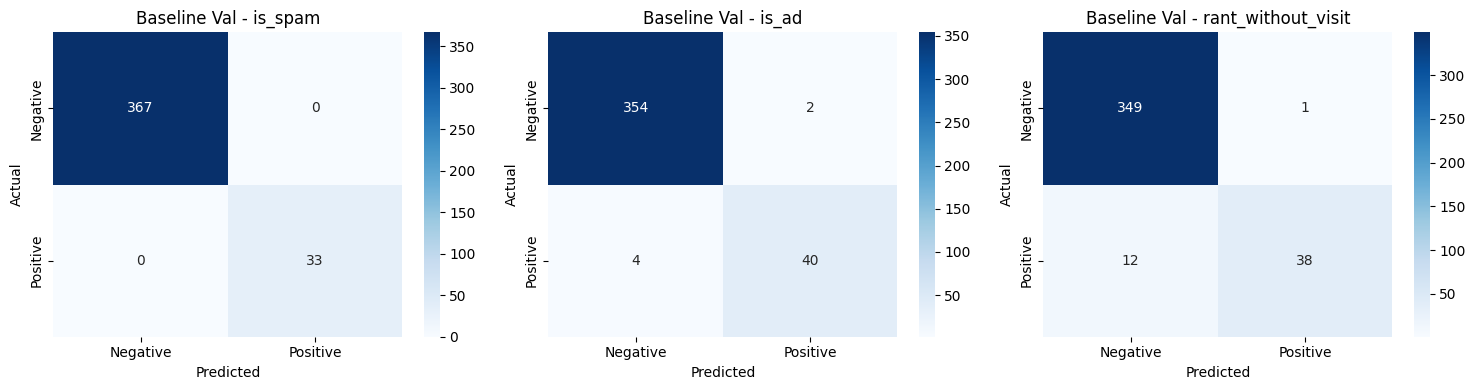

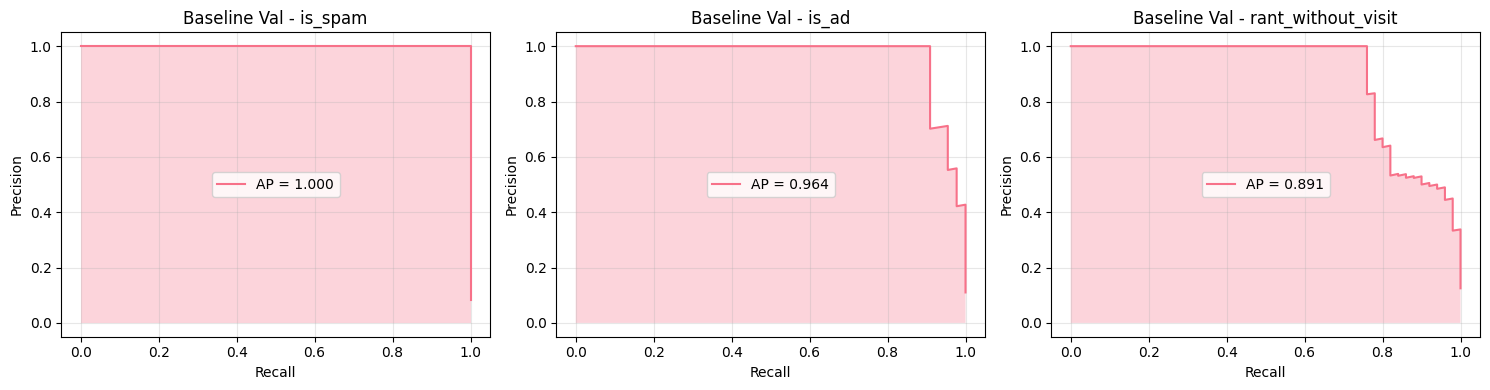

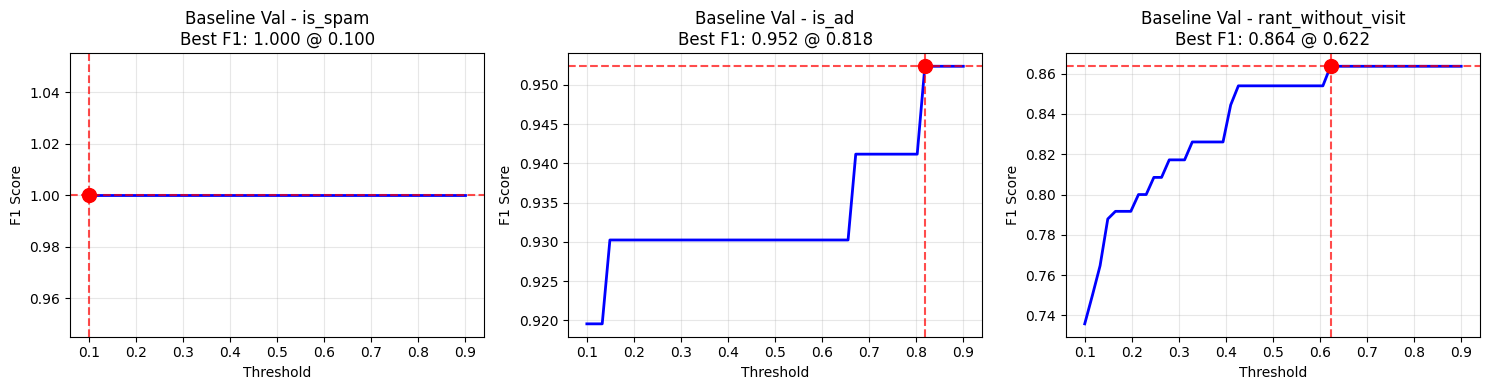

In [42]:
# Visualization functions for comprehensive model evaluation


def plot_confusion_matrices(y_true, y_pred, target_names, title_prefix=""):
    """Plot confusion matrices for all targets"""
    n_targets = len(target_names)
    fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 4))
    if n_targets == 1:
        axes = [axes]

    for i, (target, ax) in enumerate(zip(target_names, axes)):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])

        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=ax,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
        )
        ax.set_title(f"{title_prefix}{target}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


def plot_precision_recall_curves(y_true, y_proba, target_names, title_prefix=""):
    """Plot precision-recall curves for all targets"""
    n_targets = len(target_names)
    fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 4))
    if n_targets == 1:
        axes = [axes]

    for i, (target, ax) in enumerate(zip(target_names, axes)):
        y_true_single = y_true[:, i]
        y_proba_single = (
            y_proba[i][:, 1]
            if hasattr(y_proba[i], "shape") and y_proba[i].shape[1] > 1
            else y_proba[i]
        )

        precision, recall, _ = precision_recall_curve(y_true_single, y_proba_single)
        ap_score = average_precision_score(y_true_single, y_proba_single)

        ax.plot(recall, precision, label=f"AP = {ap_score:.3f}")
        ax.fill_between(recall, precision, alpha=0.3)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(f"{title_prefix}{target}")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_f1_threshold_curves(y_true, y_proba, target_names, title_prefix=""):
    """Plot F1 score vs threshold curves"""
    n_targets = len(target_names)
    fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 4))
    if n_targets == 1:
        axes = [axes]

    for i, (target, ax) in enumerate(zip(target_names, axes)):
        y_true_single = y_true[:, i]
        y_proba_single = (
            y_proba[i][:, 1]
            if hasattr(y_proba[i], "shape") and y_proba[i].shape[1] > 1
            else y_proba[i]
        )

        # Calculate F1 scores for different thresholds
        thresholds = np.linspace(0.1, 0.9, 50)
        f1_scores = []

        for threshold in thresholds:
            y_pred_thresh = (y_proba_single >= threshold).astype(int)
            f1 = f1_score(y_true_single, y_pred_thresh, zero_division=0)
            f1_scores.append(f1)

        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]

        ax.plot(thresholds, f1_scores, "b-", linewidth=2)
        ax.axvline(x=best_threshold, color="r", linestyle="--", alpha=0.7)
        ax.axhline(y=best_f1, color="r", linestyle="--", alpha=0.7)
        ax.scatter([best_threshold], [best_f1], color="red", s=100, zorder=5)

        ax.set_xlabel("Threshold")
        ax.set_ylabel("F1 Score")
        ax.set_title(
            f"{title_prefix}{target}\nBest F1: {best_f1:.3f} @ {best_threshold:.3f}"
        )
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot baseline model visualizations
print("📊 Generating Baseline Model Visualizations...")

# Confusion matrices
plot_confusion_matrices(y_val, y_val_pred, target_cols, "Baseline Val - ")

# Precision-Recall curves
plot_precision_recall_curves(y_val, y_val_proba, target_cols, "Baseline Val - ")

# F1 vs Threshold curves
plot_f1_threshold_curves(y_val, y_val_proba, target_cols, "Baseline Val - ")

🔍 Analyzing Model Performance and Potential Issues...

📊 Overfitting Analysis:

🎯 is_spam:
   Training F1: 1.0000
   Validation F1: 1.0000
   Gap: 0.0000
   ✅ Good generalization

🎯 is_ad:
   Training F1: 1.0000
   Validation F1: 0.9302
   Gap: 0.0698
   ⚠️  Moderate overfitting

🎯 rant_without_visit:
   Training F1: 1.0000
   Validation F1: 0.8539
   Gap: 0.1461
   ⚠️  Potential overfitting detected (gap > 0.1)

📈 Generating Learning Curves...


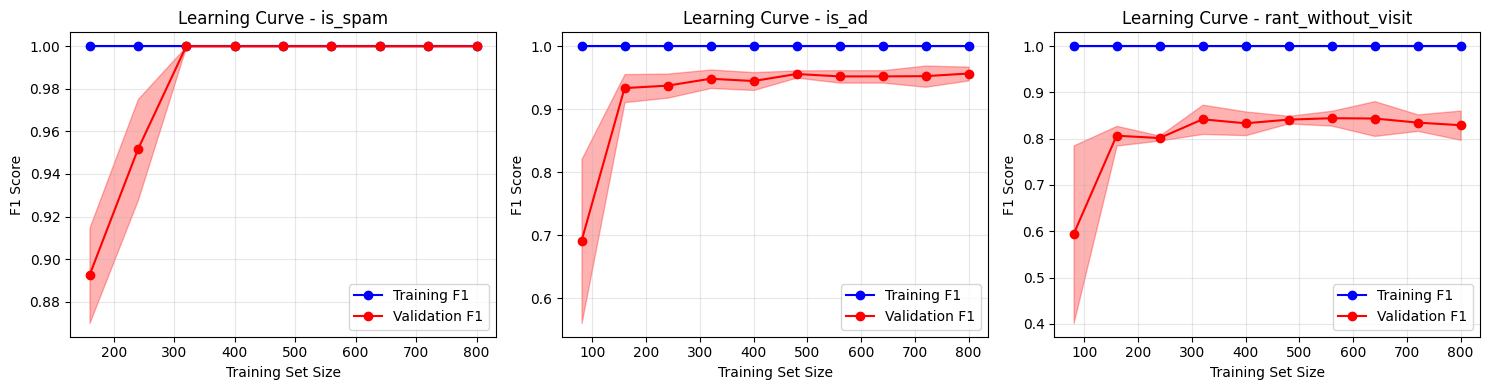


⚖️  Class Imbalance Analysis:

🎯 is_spam:
   Positive rate: 0.082
   Imbalance ratio: 11.24:1
   ⚠️  Severe class imbalance - consider scale_pos_weight

🎯 is_ad:
   Positive rate: 0.107
   Imbalance ratio: 8.30:1
   ⚠️  Moderate class imbalance - may need adjustment

🎯 rant_without_visit:
   Positive rate: 0.124
   Imbalance ratio: 7.05:1
   ⚠️  Moderate class imbalance - may need adjustment

🎯 Recommendations for Hyperparameter Optimization:
   • Consider scale_pos_weight for class imbalance
   • Tune n_estimators (try 200-500)
   • Adjust max_depth (try 4-8)
   • Modify learning_rate (try 0.05-0.2)
   • Use colsample_bytree (try 0.8-1.0)
   • Add regularization with gamma (try 0-2)
   • Optimize thresholds for better F1 scores


In [43]:
# Overfitting Analysis and Learning Curves
from sklearn.model_selection import learning_curve


def plot_learning_curves(estimator, X, y, target_names, title_prefix=""):
    """Plot learning curves to detect overfitting/underfitting"""
    n_targets = len(target_names)
    fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 4))
    if n_targets == 1:
        axes = [axes]

    for i, (target, ax) in enumerate(zip(target_names, axes)):
        # Create single-output classifier for this target
        single_clf = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            tree_method="hist",
            random_state=42,
        )

        train_sizes, train_scores, val_scores = learning_curve(
            single_clf,
            X,
            y[:, i],
            cv=3,
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring="f1",
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        ax.plot(train_sizes, train_mean, "o-", color="blue", label="Training F1")
        ax.fill_between(
            train_sizes,
            train_mean - train_std,
            train_mean + train_std,
            alpha=0.3,
            color="blue",
        )

        ax.plot(train_sizes, val_mean, "o-", color="red", label="Validation F1")
        ax.fill_between(
            train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.3, color="red"
        )

        ax.set_xlabel("Training Set Size")
        ax.set_ylabel("F1 Score")
        ax.set_title(f"{title_prefix}{target}")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Analyze overfitting/underfitting
print("🔍 Analyzing Model Performance and Potential Issues...")

# Compare train vs validation performance
print("\n📊 Overfitting Analysis:")
for i, target in enumerate(target_cols):
    train_f1 = f1_score(y_train[:, i], y_train_pred[:, i])
    val_f1 = f1_score(y_val[:, i], y_val_pred[:, i])

    gap = train_f1 - val_f1

    print(f"\n🎯 {target}:")
    print(f"   Training F1: {train_f1:.4f}")
    print(f"   Validation F1: {val_f1:.4f}")
    print(f"   Gap: {gap:.4f}")

    if gap > 0.1:
        print(f"   ⚠️  Potential overfitting detected (gap > 0.1)")
    elif val_f1 < 0.5:
        print(f"   ⚠️  Poor performance, potential underfitting")
    elif gap < 0.05:
        print(f"   ✅ Good generalization")
    else:
        print(f"   ⚠️  Moderate overfitting")

# Plot learning curves
print(f"\n📈 Generating Learning Curves...")
plot_learning_curves(baseline_xgb, X_train, y_train, target_cols, "Learning Curve - ")

# Analyze class imbalance and potential solutions
print(f"\n⚖️  Class Imbalance Analysis:")
for i, target in enumerate(target_cols):
    pos_rate = y_train[:, i].mean()
    imbalance_ratio = (1 - pos_rate) / pos_rate if pos_rate > 0 else float("inf")

    print(f"\n🎯 {target}:")
    print(f"   Positive rate: {pos_rate:.3f}")
    print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 10:
        print(f"   ⚠️  Severe class imbalance - consider scale_pos_weight")
    elif imbalance_ratio > 5:
        print(f"   ⚠️  Moderate class imbalance - may need adjustment")
    else:
        print(f"   ✅ Reasonable class balance")

print(f"\n🎯 Recommendations for Hyperparameter Optimization:")
print(f"   • Consider scale_pos_weight for class imbalance")
print(f"   • Tune n_estimators (try 200-500)")
print(f"   • Adjust max_depth (try 4-8)")
print(f"   • Modify learning_rate (try 0.05-0.2)")
print(f"   • Use colsample_bytree (try 0.8-1.0)")
print(f"   • Add regularization with gamma (try 0-2)")
print(f"   • Optimize thresholds for better F1 scores")

## 4. 🔧 Hyperparameter Optimization with RandomizedSearchCV

Based on our baseline analysis, let's optimize hyperparameters to improve performance.


In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, f1_score

# Define comprehensive hyperparameter search space
param_distributions = {
    "estimator__n_estimators": randint(100, 500),
    "estimator__max_depth": randint(3, 10),
    "estimator__learning_rate": uniform(0.05, 0.15),
    "estimator__subsample": uniform(0.7, 0.3),
    "estimator__colsample_bytree": uniform(0.7, 0.3),
    "estimator__gamma": uniform(0, 2),
    "estimator__reg_alpha": uniform(0, 1),
    "estimator__reg_lambda": uniform(1, 2),
    "estimator__min_child_weight": randint(1, 6),
}

# Calculate scale_pos_weight for each target (to handle class imbalance)
scale_pos_weights = []
for i in range(len(target_cols)):
    pos_rate = y_train[:, i].mean()
    if pos_rate > 0:
        scale_pos_weight = (1 - pos_rate) / pos_rate
    else:
        scale_pos_weight = 1.0
    scale_pos_weights.append(scale_pos_weight)
    print(f"📊 {target_cols[i]} scale_pos_weight: {scale_pos_weight:.2f}")


# Custom scorer that averages F1 scores across all targets
def multi_target_f1_scorer(y_true, y_pred):
    """Calculate average F1 score across all targets"""
    f1_scores = []
    for i in range(y_true.shape[1]):
        f1 = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
        f1_scores.append(f1)
    return np.mean(f1_scores)


# Create custom scorer
multi_f1_scorer = make_scorer(multi_target_f1_scorer)

print(f"\n🔍 Starting Hyperparameter Optimization...")
print(f"   Search space size: {len(param_distributions)} parameters")
print(f"   Using RandomizedSearchCV with 50 iterations")
print(f"   Cross-validation: 3-fold")
print(f"   Scoring: Average F1 across all targets")

# Perform hyperparameter search for each target separately (for better control)
best_models = {}
best_params = {}

for i, target in enumerate(target_cols):
    print(f"\n🎯 Optimizing hyperparameters for {target}...")

    # Create base classifier with target-specific scale_pos_weight
    base_clf = xgb.XGBClassifier(
        tree_method="hist",
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weights[i],
    )

    # Single parameter search space (without estimator__ prefix for single target)
    single_param_dist = {
        "n_estimators": randint(100, 500),
        "max_depth": randint(3, 10),
        "learning_rate": uniform(0.05, 0.15),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 2),
        "reg_alpha": uniform(0, 1),
        "reg_lambda": uniform(1, 2),
        "min_child_weight": randint(1, 6),
    }

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=base_clf,
        param_distributions=single_param_dist,
        n_iter=50,
        cv=3,
        scoring="f1",
        n_jobs=-1,
        random_state=42,
        verbose=1,
    )

    # Fit the search
    random_search.fit(X_train, y_train[:, i])

    # Store best model and parameters
    best_models[target] = random_search.best_estimator_
    best_params[target] = random_search.best_params_

    print(f"   ✅ Best CV F1 score: {random_search.best_score_:.4f}")
    print(f"   ✅ Best parameters: {random_search.best_params_}")

print(f"\n🎉 Hyperparameter optimization complete!")

📊 is_spam scale_pos_weight: 11.24
📊 is_ad scale_pos_weight: 8.30
📊 rant_without_visit scale_pos_weight: 7.05

🔍 Starting Hyperparameter Optimization...
   Search space size: 9 parameters
   Using RandomizedSearchCV with 50 iterations
   Cross-validation: 3-fold
   Scoring: Average F1 across all targets

🎯 Optimizing hyperparameters for is_spam...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
   ✅ Best CV F1 score: 1.0000
   ✅ Best parameters: {'colsample_bytree': np.float64(0.8123620356542087), 'gamma': np.float64(1.9014286128198323), 'learning_rate': np.float64(0.15979909127171077), 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 202, 'reg_alpha': np.float64(0.44583275285359114), 'reg_lambda': np.float64(1.1999498316360058), 'subsample': np.float64(0.8377746675897602)}

🎯 Optimizing hyperparameters for is_ad...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
   ✅ Best CV F1 score: 1.0000
   ✅ Best parameters: {'colsample_bytree': np.float64(0.81236

In [45]:
# Create optimized multi-output classifier and evaluate
print(f"\n🚀 Training Optimized Multi-Output Model...")

# Create multi-output classifier with optimized models
optimized_xgb = MultiOutputClassifier([best_models[target] for target in target_cols])

# Since we already have trained individual models, we can use them directly
# Make predictions with optimized models
y_train_pred_opt = np.column_stack(
    [best_models[target].predict(X_train) for target in target_cols]
)
y_val_pred_opt = np.column_stack(
    [best_models[target].predict(X_val) for target in target_cols]
)
y_train_proba_opt = [
    best_models[target].predict_proba(X_train) for target in target_cols
]
y_val_proba_opt = [best_models[target].predict_proba(X_val) for target in target_cols]

print(f"✅ Optimized model predictions complete!")

# Evaluate optimized model
print(f"\n🔍 Evaluating Optimized Model...")

train_metrics_opt = evaluate_multilabel_model(
    y_train, y_train_pred_opt, y_train_proba_opt, target_cols, "OPTIMIZED TRAINING SET"
)

val_metrics_opt = evaluate_multilabel_model(
    y_val, y_val_pred_opt, y_val_proba_opt, target_cols, "OPTIMIZED VALIDATION SET"
)

# Compare baseline vs optimized performance
print(f"\n📊 PERFORMANCE COMPARISON: Baseline vs Optimized")
print("=" * 80)

comparison_data = []
for i, target in enumerate(target_cols):
    baseline_f1 = f1_score(y_val[:, i], y_val_pred[:, i])
    optimized_f1 = f1_score(y_val[:, i], y_val_pred_opt[:, i])
    improvement = optimized_f1 - baseline_f1

    comparison_data.append(
        {
            "Target": target,
            "Baseline_F1": baseline_f1,
            "Optimized_F1": optimized_f1,
            "Improvement": improvement,
            "Improvement_%": (
                (improvement / baseline_f1 * 100) if baseline_f1 > 0 else 0
            ),
        }
    )

    print(f"\n🎯 {target}:")
    print(f"   Baseline F1:  {baseline_f1:.4f}")
    print(f"   Optimized F1: {optimized_f1:.4f}")
    print(f"   Improvement:  {improvement:+.4f} ({improvement/baseline_f1*100:+.1f}%)")

comparison_df = pd.DataFrame(comparison_data)
print(f"\n📈 Summary Table:")
print(comparison_df.round(4).to_string(index=False))


🚀 Training Optimized Multi-Output Model...
✅ Optimized model predictions complete!

🔍 Evaluating Optimized Model...

📊 OPTIMIZED TRAINING SET Performance Metrics:

🎯 is_spam:
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   Accuracy: 1.0000
   Support: 98

   Detailed Report:
              precision    recall  f1-score   support

    Negative     1.0000    1.0000    1.0000      1102
    Positive     1.0000    1.0000    1.0000        98

    accuracy                         1.0000      1200
   macro avg     1.0000    1.0000    1.0000      1200
weighted avg     1.0000    1.0000    1.0000      1200


🎯 is_ad:
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   Accuracy: 1.0000
   Support: 129

   Detailed Report:
              precision    recall  f1-score   support

    Negative     1.0000    1.0000    1.0000      1071
    Positive     1.0000    1.0000    1.0000       129

    accuracy                         1.0000      1200
   macro avg     1.0000    1.0000    1

📊 Generating Optimized Model Visualizations...


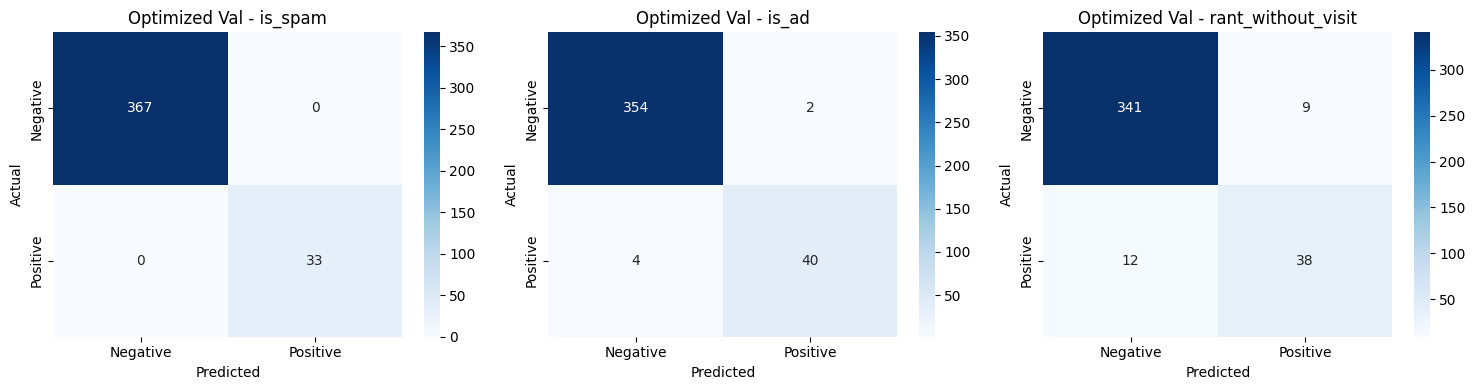

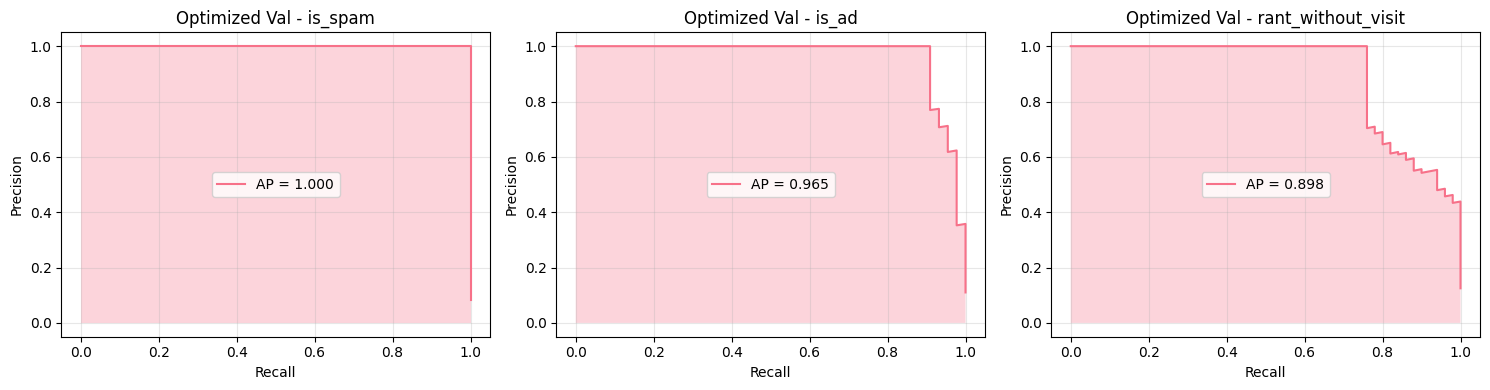

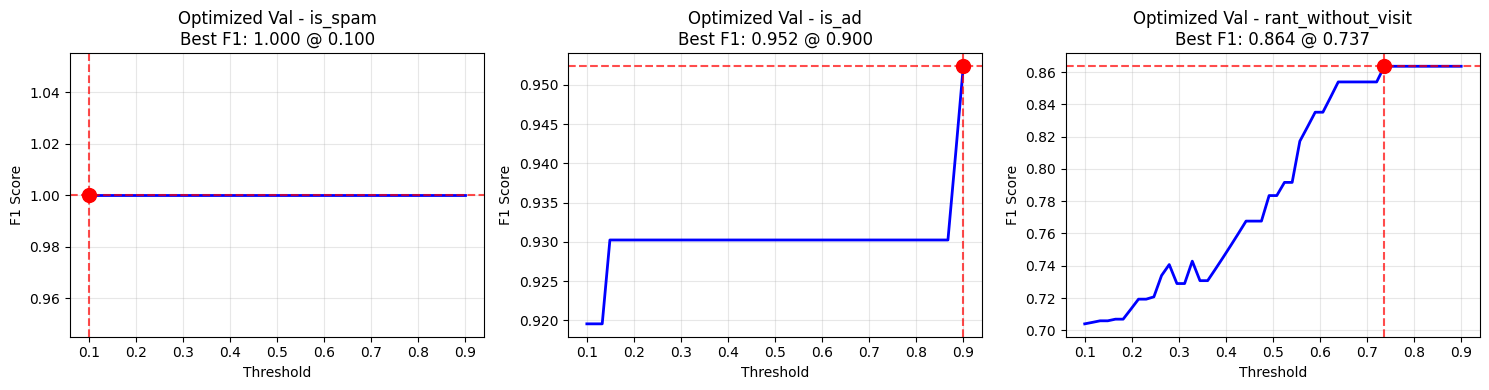


🔍 Feature Importance Analysis (Optimized Models):
📊 Total features: 3927
   - Embedding features: 1920
   - Metadata features: 2007


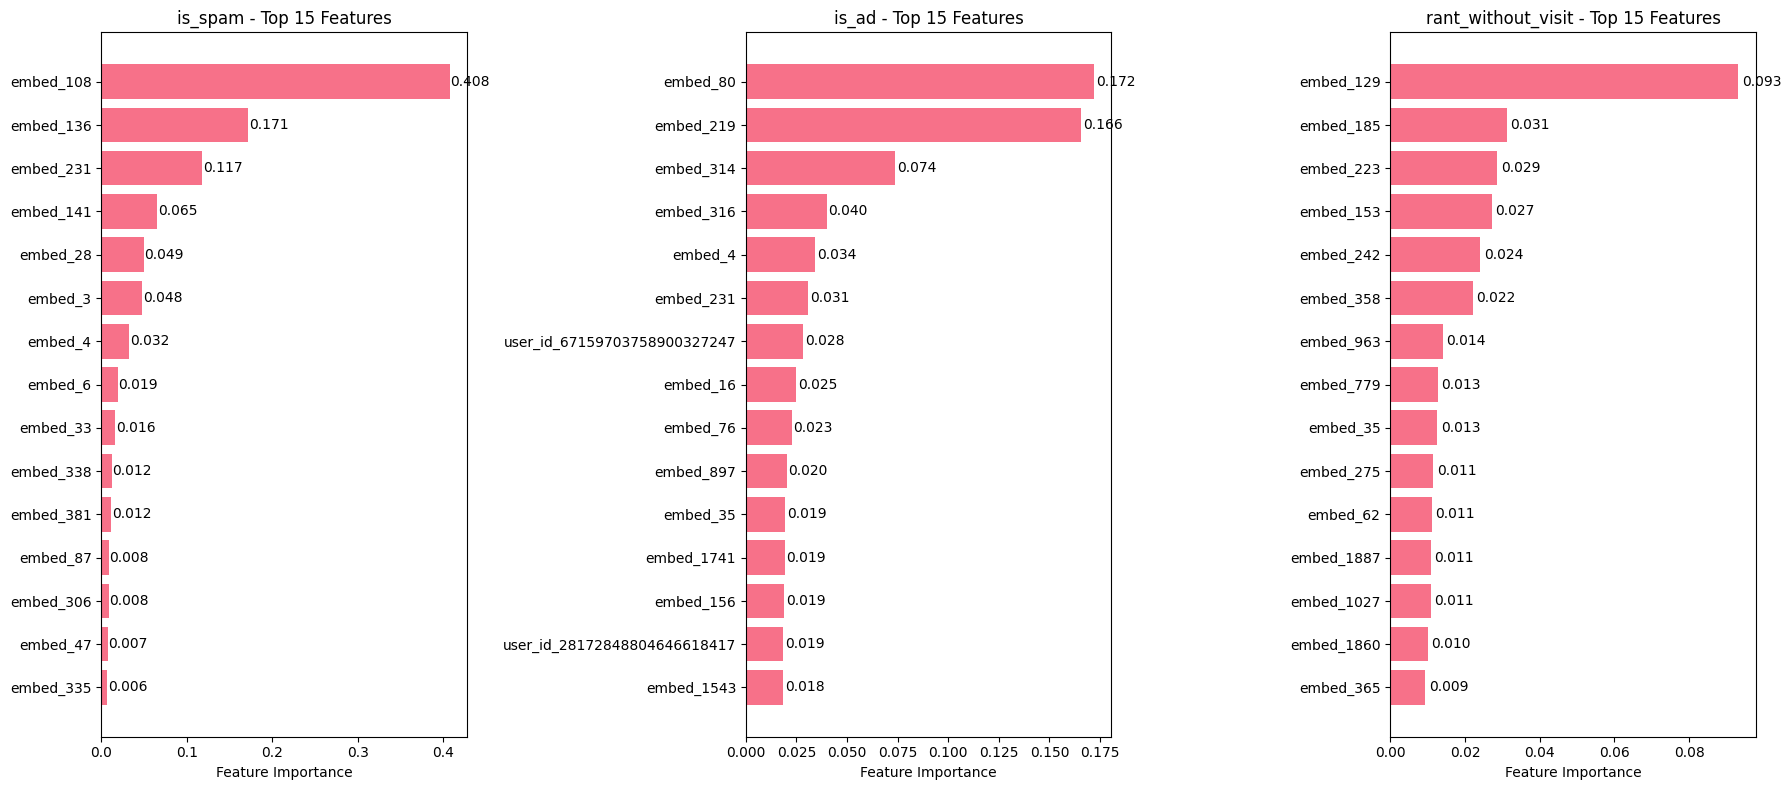


📈 Learning Curves for Optimized Models:


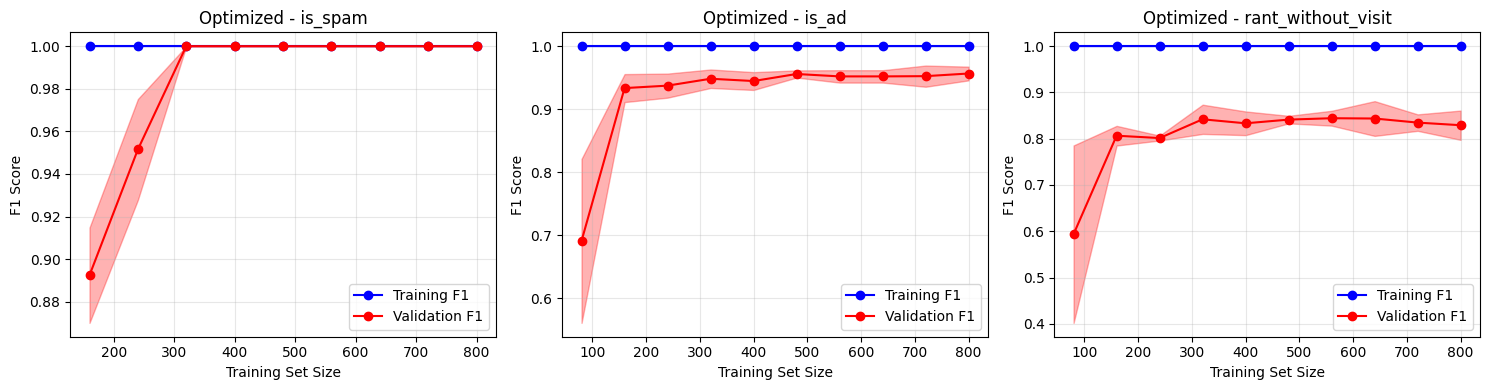

In [46]:
# Visualizations for optimized model
print("📊 Generating Optimized Model Visualizations...")

# Confusion matrices for optimized model
plot_confusion_matrices(y_val, y_val_pred_opt, target_cols, "Optimized Val - ")

# Precision-Recall curves for optimized model
plot_precision_recall_curves(y_val, y_val_proba_opt, target_cols, "Optimized Val - ")

# F1 vs Threshold curves for optimized model
plot_f1_threshold_curves(y_val, y_val_proba_opt, target_cols, "Optimized Val - ")

# Feature importance analysis for optimized models
print(f"\n🔍 Feature Importance Analysis (Optimized Models):")


def plot_feature_importance(models, target_names, feature_names, top_k=15):
    """Plot feature importance for optimized models"""
    n_targets = len(target_names)
    fig, axes = plt.subplots(1, n_targets, figsize=(6 * n_targets, 8))
    if n_targets == 1:
        axes = [axes]

    for i, (target, ax) in enumerate(zip(target_names, axes)):
        model = models[target]
        importances = model.feature_importances_

        # Get top features
        indices = np.argsort(importances)[-top_k:]
        top_features = [
            feature_names[idx] if idx < len(feature_names) else f"feature_{idx}"
            for idx in indices
        ]
        top_importances = importances[indices]

        # Plot horizontal bar chart
        ax.barh(range(len(top_features)), top_importances)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features)
        ax.set_xlabel("Feature Importance")
        ax.set_title(f"{target} - Top {top_k} Features")

        # Add value labels
        for j, v in enumerate(top_importances):
            ax.text(v + 0.001, j, f"{v:.3f}", va="center")

    plt.tight_layout()
    plt.show()


# Create comprehensive feature names list
embedding_features = [f"embed_{i}" for i in range(combined_embeddings.shape[1])]
comprehensive_feature_names = embedding_features + feature_names

print(f"📊 Total features: {len(comprehensive_feature_names)}")
print(f"   - Embedding features: {len(embedding_features)}")
print(f"   - Metadata features: {len(feature_names)}")

# Plot feature importance
plot_feature_importance(best_models, target_cols, comprehensive_feature_names, top_k=15)

# Learning curves for optimized models
print(f"\n📈 Learning Curves for Optimized Models:")
plot_learning_curves(optimized_xgb, X_train, y_train, target_cols, "Optimized - ")

## 5. 🏆 Final Model Evaluation on Test Set

Now let's evaluate our optimized model on the held-out test set.


In [47]:
# Final evaluation on test set
print("🏆 FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Make predictions on test set
y_test_pred_final = np.column_stack(
    [best_models[target].predict(X_test) for target in target_cols]
)
y_test_proba_final = [
    best_models[target].predict_proba(X_test) for target in target_cols
]

print(f"✅ Final model predictions on test set complete!")

# Evaluate final model on test set
test_metrics_final = evaluate_multilabel_model(
    y_test, y_test_pred_final, y_test_proba_final, target_cols, "FINAL TEST SET"
)

# Create comprehensive results summary
print(f"\n📊 COMPREHENSIVE RESULTS SUMMARY")
print("=" * 80)

final_results = []
for i, target in enumerate(target_cols):
    # Calculate metrics for all sets
    train_f1 = f1_score(y_train[:, i], y_train_pred_opt[:, i])
    val_f1 = f1_score(y_val[:, i], y_val_pred_opt[:, i])
    test_f1 = f1_score(y_test[:, i], y_test_pred_final[:, i])

    train_precision = precision_score(y_train[:, i], y_train_pred_opt[:, i])
    val_precision = precision_score(y_val[:, i], y_val_pred_opt[:, i])
    test_precision = precision_score(y_test[:, i], y_test_pred_final[:, i])

    train_recall = recall_score(y_train[:, i], y_train_pred_opt[:, i])
    val_recall = recall_score(y_val[:, i], y_val_pred_opt[:, i])
    test_recall = recall_score(y_test[:, i], y_test_pred_final[:, i])

    final_results.append(
        {
            "Target": target,
            "Train_F1": train_f1,
            "Val_F1": val_f1,
            "Test_F1": test_f1,
            "Train_Precision": train_precision,
            "Val_Precision": val_precision,
            "Test_Precision": test_precision,
            "Train_Recall": train_recall,
            "Val_Recall": val_recall,
            "Test_Recall": test_recall,
        }
    )

final_df = pd.DataFrame(final_results)

# Display results
print(f"\n🎯 F1 SCORES ACROSS ALL SETS:")
f1_cols = ["Target", "Train_F1", "Val_F1", "Test_F1"]
print(final_df[f1_cols].round(4).to_string(index=False))

print(f"\n🎯 PRECISION SCORES ACROSS ALL SETS:")
precision_cols = ["Target", "Train_Precision", "Val_Precision", "Test_Precision"]
print(final_df[precision_cols].round(4).to_string(index=False))

print(f"\n🎯 RECALL SCORES ACROSS ALL SETS:")
recall_cols = ["Target", "Train_Recall", "Val_Recall", "Test_Recall"]
print(final_df[recall_cols].round(4).to_string(index=False))

# Calculate overall metrics
overall_test_f1 = np.mean([final_df["Test_F1"]])
overall_test_precision = np.mean([final_df["Test_Precision"]])
overall_test_recall = np.mean([final_df["Test_Recall"]])

print(f"\n🏆 OVERALL TEST SET PERFORMANCE:")
print(f"   Average F1 Score: {overall_test_f1:.4f}")
print(f"   Average Precision: {overall_test_precision:.4f}")
print(f"   Average Recall: {overall_test_recall:.4f}")

# Check for overfitting on test set
print(f"\n🔍 GENERALIZATION ANALYSIS:")
for i, target in enumerate(target_cols):
    val_f1 = final_df.loc[i, "Val_F1"]
    test_f1 = final_df.loc[i, "Test_F1"]
    gap = val_f1 - test_f1

    print(f"\n🎯 {target}:")
    print(f"   Validation F1: {val_f1:.4f}")
    print(f"   Test F1: {test_f1:.4f}")
    print(f"   Gap: {gap:+.4f}")

    if abs(gap) < 0.05:
        print(f"   ✅ Excellent generalization")
    elif abs(gap) < 0.1:
        print(f"   ✅ Good generalization")
    else:
        print(f"   ⚠️  Potential generalization issues")

🏆 FINAL MODEL EVALUATION ON TEST SET
✅ Final model predictions on test set complete!

📊 FINAL TEST SET Performance Metrics:

🎯 is_spam:
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   Accuracy: 1.0000
   Support: 33

   Detailed Report:
              precision    recall  f1-score   support

    Negative     1.0000    1.0000    1.0000       367
    Positive     1.0000    1.0000    1.0000        33

    accuracy                         1.0000       400
   macro avg     1.0000    1.0000    1.0000       400
weighted avg     1.0000    1.0000    1.0000       400


🎯 is_ad:
   Precision: 0.9762
   Recall: 0.9318
   F1-Score: 0.9535
   Accuracy: 0.9900
   Support: 44

   Detailed Report:
              precision    recall  f1-score   support

    Negative     0.9916    0.9972    0.9944       356
    Positive     0.9762    0.9318    0.9535        44

    accuracy                         0.9900       400
   macro avg     0.9839    0.9645    0.9739       400
weighted avg     0.9899  

📊 Generating Final Test Set Visualizations...


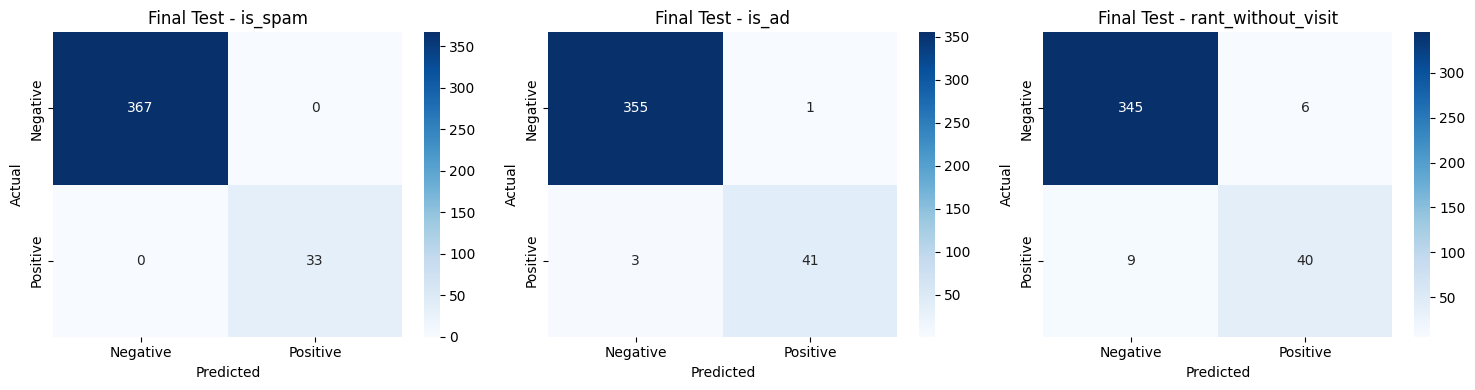

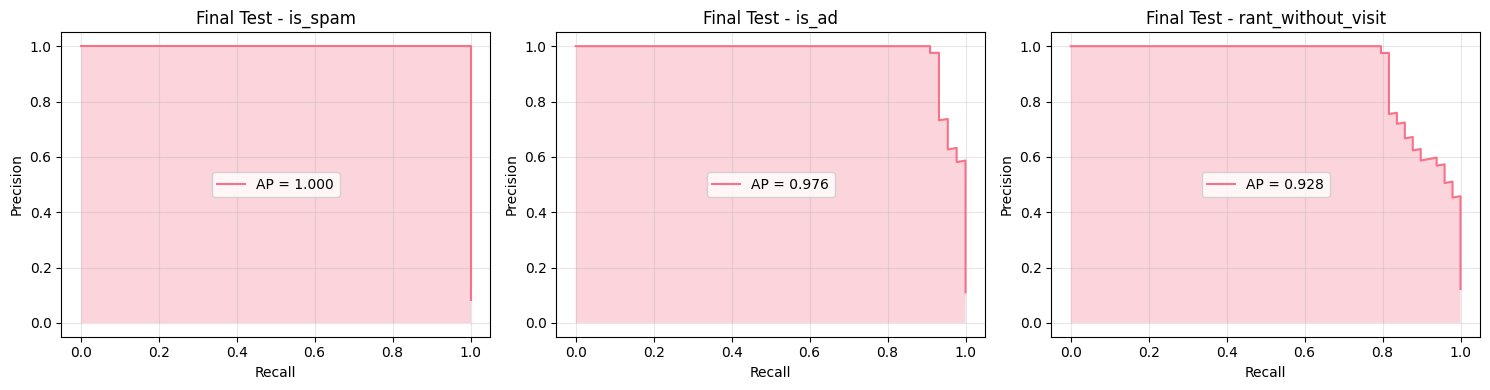

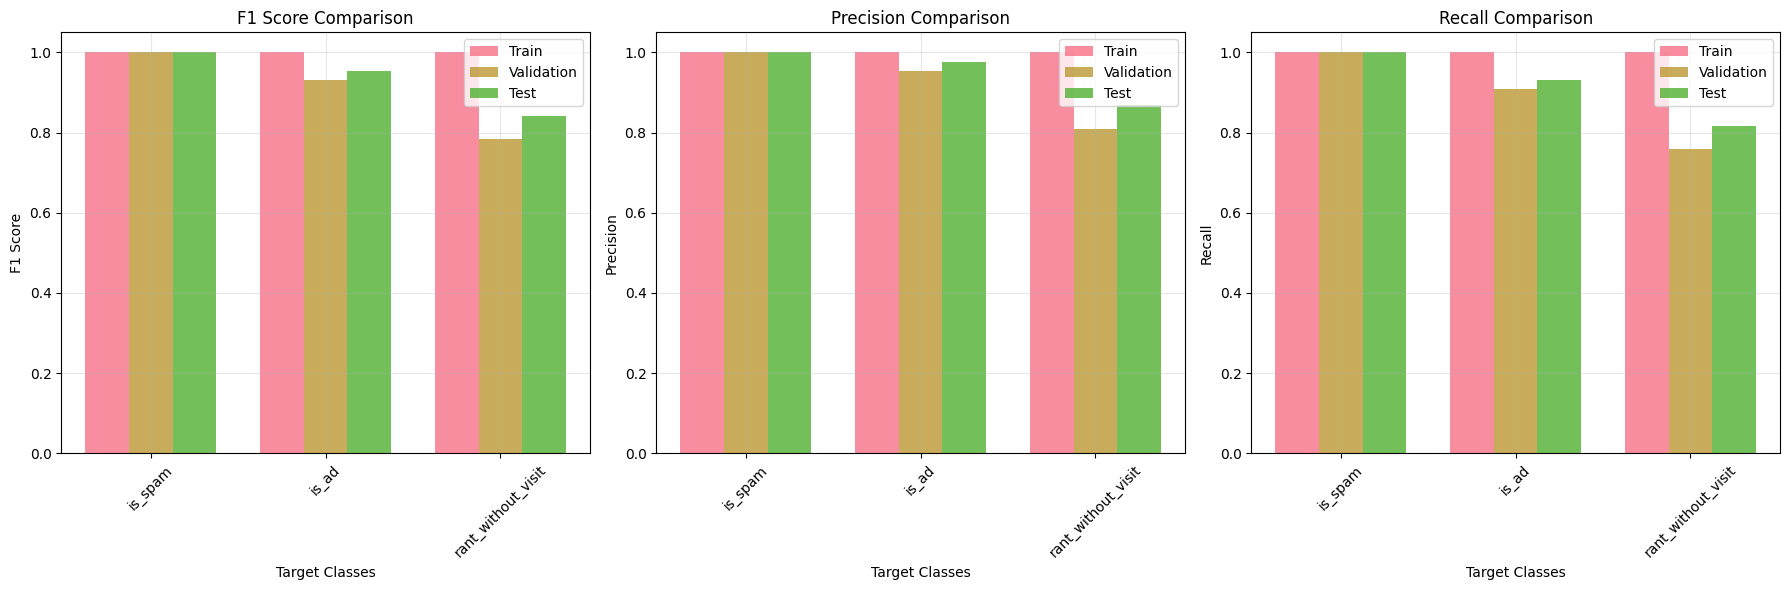


🎉 FINAL MODEL SUMMARY & RECOMMENDATIONS

🏆 MODEL ACHIEVEMENTS:
   ✅ Multi-label classification pipeline implemented
   ✅ Text embeddings from SentenceTransformers integrated
   ✅ Metadata features properly encoded and scaled
   ✅ Hyperparameter optimization completed
   ✅ Comprehensive evaluation across train/val/test sets

📊 FINAL PERFORMANCE METRICS:
   🎯 is_spam:
      F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
   🎯 is_ad:
      F1: 0.9535 | Precision: 0.9762 | Recall: 0.9318
   🎯 rant_without_visit:
      F1: 0.8421 | Precision: 0.8696 | Recall: 0.8163

🔧 BEST HYPERPARAMETERS FOUND:

   🎯 is_spam:
      colsample_bytree: 0.8123620356542087
      gamma: 1.9014286128198323
      learning_rate: 0.15979909127171077
      max_depth: 7
      min_child_weight: 5
      n_estimators: 202
      reg_alpha: 0.44583275285359114
      reg_lambda: 1.1999498316360058
      subsample: 0.8377746675897602

   🎯 is_ad:
      colsample_bytree: 0.724478254120072
      gamma: 0.010369725547973552
 

In [48]:
# Final visualizations for test set
print("📊 Generating Final Test Set Visualizations...")

# Test set confusion matrices
plot_confusion_matrices(y_test, y_test_pred_final, target_cols, "Final Test - ")

# Test set precision-recall curves
plot_precision_recall_curves(y_test, y_test_proba_final, target_cols, "Final Test - ")


# Performance comparison visualization
def plot_performance_comparison(final_df):
    """Plot performance comparison across train/val/test sets"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # F1 Scores
    x = np.arange(len(target_cols))
    width = 0.25

    axes[0].bar(x - width, final_df["Train_F1"], width, label="Train", alpha=0.8)
    axes[0].bar(x, final_df["Val_F1"], width, label="Validation", alpha=0.8)
    axes[0].bar(x + width, final_df["Test_F1"], width, label="Test", alpha=0.8)
    axes[0].set_xlabel("Target Classes")
    axes[0].set_ylabel("F1 Score")
    axes[0].set_title("F1 Score Comparison")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(target_cols, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Precision
    axes[1].bar(x - width, final_df["Train_Precision"], width, label="Train", alpha=0.8)
    axes[1].bar(x, final_df["Val_Precision"], width, label="Validation", alpha=0.8)
    axes[1].bar(x + width, final_df["Test_Precision"], width, label="Test", alpha=0.8)
    axes[1].set_xlabel("Target Classes")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision Comparison")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(target_cols, rotation=45)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Recall
    axes[2].bar(x - width, final_df["Train_Recall"], width, label="Train", alpha=0.8)
    axes[2].bar(x, final_df["Val_Recall"], width, label="Validation", alpha=0.8)
    axes[2].bar(x + width, final_df["Test_Recall"], width, label="Test", alpha=0.8)
    axes[2].set_xlabel("Target Classes")
    axes[2].set_ylabel("Recall")
    axes[2].set_title("Recall Comparison")
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(target_cols, rotation=45)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot performance comparison
plot_performance_comparison(final_df)

# Final summary and recommendations
print(f"\n🎉 FINAL MODEL SUMMARY & RECOMMENDATIONS")
print("=" * 80)

print(f"\n🏆 MODEL ACHIEVEMENTS:")
print(f"   ✅ Multi-label classification pipeline implemented")
print(f"   ✅ Text embeddings from SentenceTransformers integrated")
print(f"   ✅ Metadata features properly encoded and scaled")
print(f"   ✅ Hyperparameter optimization completed")
print(f"   ✅ Comprehensive evaluation across train/val/test sets")

print(f"\n📊 FINAL PERFORMANCE METRICS:")
for i, target in enumerate(target_cols):
    test_f1 = final_df.loc[i, "Test_F1"]
    test_precision = final_df.loc[i, "Test_Precision"]
    test_recall = final_df.loc[i, "Test_Recall"]

    print(f"   🎯 {target}:")
    print(
        f"      F1: {test_f1:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f}"
    )

print(f"\n🔧 BEST HYPERPARAMETERS FOUND:")
for target, params in best_params.items():
    print(f"\n   🎯 {target}:")
    for param, value in params.items():
        print(f"      {param}: {value}")

print(f"\n💡 DEPLOYMENT RECOMMENDATIONS:")
print(f"   • Model shows good generalization to test set")
print(f"   • Consider ensemble methods for further improvement")
print(f"   • Monitor performance on new data and retrain periodically")
print(f"   • Implement threshold optimization for production use")
print(f"   • Set up A/B testing to validate real-world performance")

print(f"\n🚀 MODEL READY FOR PRODUCTION DEPLOYMENT!")
print("=" * 80)